The goal here is to look into the people that tweet because of the hashtag. What do they generally look like? Generate descriptive statistics (both network and Twitter based) and contrast them with other user types.

In [1]:
from imports import * 

In [2]:
campaigns = preprocessing.load_campaign()
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

In [3]:
with open(os.path.join(TWITTER_DATA_DIR, 'n_newly_exposed_by_user.pkl'), 'rb') as f:
    new_exposures = pickle.load(f)

new_exposures_df = pd.DataFrame(pd.DataFrame(new_exposures).T.stack())
new_exposures_df.index = new_exposures_df.index.set_names(['hashtag', 'username'])
new_exposures_df.columns = ['newly_exposed_users']
new_exposures_df.head()

newly_exposed_users
hashtag           username                            
jharkhandwithmodi manojgoelbjp                 13636.0
                  moonmuks                         0.0
                  sanjay_mishra91               1828.0
                  ch_rahul29                     932.0
                  shaileshmishra                2043.0

In [4]:
dfs = []
for hashtag, tweets in tqdm(campaigns.items()):
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        _, df = trending.build_df(hashtag, tweets, exposures, 
                                  raw_df_too=True, include_missing=False, 
                                  cutoff_choice='earliest')
        dfs.append(df.merge(new_exposures_df.reset_index(), on=['username', 'hashtag']))
panel_df = pd.concat(dfs)
panel_df.head()

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,type,follower_data,template_exposure,normal_exposure,total_exposure,time,trending_start,inferred_trending_start,hashtag,newly_exposed_users
0,bjp4latehar,1172033856607682560,,,,आधारभूत संरचना हो या शिक्षा या फिर स्वच्छता या...,2019-09-12 06:27:01,0,0,2019-09-12 11:57:01,regular,True,151,64,215,2019-09-12 11:57:01,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
1,bjp4latehar,1172027968400445440,,,,झारखण्ड सरकार किसी भी आपात स्थिति में पीड़ित क...,2019-09-12 06:03:37,0,0,2019-09-12 11:33:37,regular,True,151,64,215,2019-09-12 11:33:37,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
2,bjp4latehar,1172028765326569472,,,,अब राजपत्रित नौकरियों को छोड़कर सभी सरकारी नौक...,2019-09-12 06:06:47,0,0,2019-09-12 11:36:47,regular,True,151,64,215,2019-09-12 11:36:47,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
3,bjp4latehar,1172029990159781888,,,,झारखण्ड गठन के बाद पहली बार रघुवर सरकार ने राज...,2019-09-12 06:11:39,0,0,2019-09-12 11:41:39,regular,True,151,64,215,2019-09-12 11:41:39,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
4,bjp4latehar,1172086387274743809,bjp4jharkhand,,1172070404157870080,rt @bjp4jharkhand: आज का दिन झारखंड के लिए ऐति...,2019-09-12 09:55:45,31,0,2019-09-12 15:25:45,regular_retweet,True,151,64,215,2019-09-12 15:25:45,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0


## Network Level Info

In [5]:
network_user_df = pd.read_pickle(os.path.join(TWITTER_DATA_DIR, 'user_network_stats.pkl'))
network_user_df

,pr,cc,outdeg,indeg
0001atulrai,0.000003,0.995769,42.0,20.0
0001sudarshan,0.000003,0.279654,86.0,48.0
0006subhash,0.000002,0.339958,76.0,6.0
000fdc0fb7974a7,0.000002,0.549075,29.0,9.0
000pal,0.000002,0.250375,107.0,3.0
...,...,...,...,...
___subodh,0.000002,0.338983,457.0,13.0
____daddysgirl,0.000002,0.000000,0.0,0.0
____realpatel__,0.000002,0.275299,196.0,41.0
_____anusha,0.000003,0.396820,177.0,20.0


In [6]:
# import network_plots, graph_tool.all as gt, gzip
# g = network_plots.load_follower_network()

# pr = gt.pagerank(g).a
# clustering = gt.local_clustering(g).a
# out_degs = g.get_out_degrees(g.get_vertices())
# in_degs = g.get_in_degrees(g.get_vertices())
# usernames = [g.vp.usernames[v] for v in g.vertices()]

# network_user_df = pd.DataFrame([pr,clustering,out_degs,in_degs]).T
# network_user_df.index = usernames
# network_user_df.columns = ['pr', 'cc', 'outdeg', 'indeg']

# network_user_df.to_pickle(os.path.join(TWITTER_DATA_DIR, 'user_network_stats.pkl'))

## Analyzing Users
For each user, how many followers do they have? 

In [7]:
def describe_users(big_df):
    res_dict = {}
    stats = ['# Tweets', '# Followers', '# Campaigns', 'Avg. Retweets', 'Avg. Favorites', 
             'PageRank', 'Clustering Coef.', 'Out-Degree', 'In-Degree', 'Avg. Newly Exposed']
    def get_user_stats(df, mean=False):
        temp = [len(df)]
        username = df.username.iloc[0]
        path = os.path.join(FOLLOWER_DATA_DIR, username + '.gz')
        f = gzip.open(path, 'rb')
        try:
            followers = [x.split('\t')[1] for x in f.read().decode().strip().split('\n')]
            temp.append(len(followers))
        except Exception as e:
            print(e, 'issue with ', username)
            temp.append(-1)
        temp.append(len(df.hashtag.unique()))
        if mean:
            temp.append(df.retweets.mean())
            temp.append(df.favorites.mean())    
        else:
            temp.append(df.retweets.median())
            temp.append(df.favorites.median())    
        temp.append(df.pr.iloc[0])
        temp.append(df.cc.iloc[0])
        temp.append(df.outdeg.iloc[0])
        temp.append(df.indeg.iloc[0])
        temp.append(df.newly_exposed_users.iloc[0])
        res_dict[username] = temp

    big_df.groupby('username').apply(get_user_stats)
    t = pd.DataFrame(res_dict).T
    t.columns = stats
    return t 

In [8]:
big_panel = []
meta_df = []
def helper(df, desc):
    t = describe_users(df)
    t['Group'] = desc 
    big_panel.append(t)
    meta_df.append(
        pd.concat({desc: t.describe()}, names=['User Group']))    

In [9]:
zero_exposure_tweeters = panel_df.query('total_exposure == 0').query('type == "regular"') \
.query('adj_date > inferred_trending_start').join(network_user_df, on='username')

helper(zero_exposure_tweeters, 'Zero-Exposure, Post-Hashtag')

list index out of range issue with  movies_it


In [10]:
zero_exposure_tweeters_pre_trend = panel_df.query('total_exposure == 0').query('type == "regular"') \
    .query('adj_date < inferred_trending_start').join(network_user_df, on='username')
helper(zero_exposure_tweeters_pre_trend,  'Zero-Exposure, Pre-Hashtag')

In [11]:
others = panel_df.query('total_exposure != 0').query('type == "regular"').join(network_user_df, on='username')
helper(others, 'Exposed, Non-Template')

list index out of range issue with  faraktesuresh
list index out of range issue with  kolinilangi
list index out of range issue with  movies_it
list index out of range issue with  shyamsu08245833


In [12]:
templates = panel_df.query('type == "template"').join(network_user_df, on='username')
helper(templates, 'Template')

list index out of range issue with  faraktesuresh
list index out of range issue with  kajal_barge
list index out of range issue with  kolinilangi
list index out of range issue with  shyamsu08245833


In [13]:
res = pd.concat(meta_df)
res.index = res.index.set_names(['User Type', 'Statistic'])
res

# Tweets   # Followers  \
User Type                   Statistic                               
Zero-Exposure, Post-Hashtag count       2093.000000  2.093000e+03   
                            mean           1.568562  2.470716e+04   
                            std            1.391969  3.458384e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  6.200000e+01   
                            50%            1.000000  2.180000e+02   
                            75%            2.000000  1.089000e+03   
                            max           16.000000  1.310638e+07   
Zero-Exposure, Pre-Hashtag  count        743.000000  7.430000e+02   
                            mean           1.049798  6.362263e+04   
                            std            0.277546  7.365588e+05   
                            min            1.000000  1.000000e+00   
                            25%            1.000000  1.005000e+02   
                            50%            1.000000  3.820000e+02   
                            75%            1.000000  1.538000e+03   
                            max            5.000000  1.310638e+07   
Exposed, Non-Template       count      16328.000000  1.632800e+04   
                            mean          10.967234  2.020173e+04   
                            std           47.054696  2.522333e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  1.367500e+02   
                            50%            3.000000  4.960000e+02   
                            75%            8.000000  2.095500e+03   
                            max         2230.000000  1.310638e+07   
Template                    count       3234.000000  3.234000e+03   
                            mean          14.452381  1.164627e+04   
                            std           29.805458  1.745905e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  7.725000e+01   
                            50%            4.000000  3.800000e+02   
                            75%           13.000000  1.745750e+03   
                            max          385.000000  8.654833e+06   

                                        # Campaigns  Avg. Retweets  \
User Type                   Statistic                                
Zero-Exposure, Post-Hashtag count       2093.000000    2083.000000   
                            mean           1.568562       7.798848   
                            std            1.391969      83.119251   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                            75%            2.000000       1.000000   
                            max           16.000000    2613.000000   
Zero-Exposure, Pre-Hashtag  count        743.000000     741.000000   
                            mean           1.049798      18.117409   
                            std            0.277546     130.877701   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                            75%            1.000000       2.000000   
                            max            5.000000    2036.000000   
Exposed, Non-Template       count      16328.000000   16274.000000   
                            mean           2.288094       6.907306   
                            std            2.310269      94.964928   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                

In [14]:
temp = pd.concat(big_panel)

In [21]:
temp.to_pickle(os.path.join(TWITTER_DATA_DIR, 'all_users_by_group_earliest_cutoff.pkl'))
# temp.to_pickle(os.path.join(TWITTER_DATA_DIR, 'all_users_by_group_medians.pkl'))
# temp.to_pickle(os.path.join(TWITTER_DATA_DIR, 'all_users_by_group.pkl'))

In [4]:
temp = pd.read_pickle(os.path.join(TWITTER_DATA_DIR, 'all_users_by_group.pkl'))
temp

,# Tweets,# Followers,# Campaigns,Avg. Retweets,Avg. Favorites,PageRank,Clustering Coef.,Out-Degree,In-Degree,Avg. Newly Exposed,Group
007_joshh,2.0,40.0,1.0,0.000000,0.000000,0.000002,0.180662,240.0,3.0,13.0,"Zero-Exposure, Post-Hashtag"
1984_tweeter,1.0,9.0,1.0,0.000000,0.000000,0.000002,1.000000,3.0,0.0,5.0,"Zero-Exposure, Post-Hashtag"
1995subhampaul,1.0,159.0,1.0,0.000000,0.000000,0.000002,0.407557,26.0,13.0,71.0,"Zero-Exposure, Post-Hashtag"
1_ndia,6.0,48.0,2.0,0.166667,0.833333,0.000002,0.400000,37.0,8.0,31.0,"Zero-Exposure, Post-Hashtag"
1stindianews,1.0,113070.0,1.0,7.000000,9.000000,0.000037,0.038084,10.0,2198.0,42120.0,"Zero-Exposure, Post-Hashtag"
...,...,...,...,...,...,...,...,...,...,...,...
yuva4namo1,2.0,1.0,1.0,0.000000,0.500000,0.000002,0.300000,5.0,0.0,0.0,Template
yv4bjp,14.0,2248.0,4.0,0.357143,0.571429,0.000003,0.485781,68.0,218.0,140.0,Template
zahidpatka,16.0,3231.0,5.0,1.250000,1.812500,0.000007,0.173755,0.0,439.0,295.0,Template
zalaji_9999,2.0,51.0,1.0,0.000000,3.500000,0.000002,0.479273,102.0,12.0,8.0,Template


## Who are the Pre Hashtag Peeps

In [6]:
premies = temp.query('Group == "Zero-Exposure, Pre-Hashtag"')

In [17]:
temp.index.unique()

Index(['007_joshh', '1984_tweeter', '1995subhampaul', '1_ndia', '1stindianews',
       '300mission', '53b1598bda3740f', '5pjkmepbkte1bam', '60yearscongress',
       '62sandeep',
       ...
       'wazir_akhil', 'witty_daddy', 'yashshukla13199', 'ykmishra54',
       'yogeshk51785358', 'yogidityanath', 'ypv86cmpaxqvhj6', 'yudh4modi',
       'yugalsharma222', 'zalaji_9999'],
      dtype='object', length=18716)

In [15]:
temp['# Tweets'].sum()

249766.0

In [14]:
premies['# Tweets'].sum()/ temp.query('Group == "Zero-Exposure, Post-Hashtag"')['# Tweets'].sum()

0.17110094698189782

In [10]:
premies['# Tweets'].sum()

2656.0

In [9]:
premies.sort_values('Avg. Newly Exposed', ascending=False).head(30)

,# Tweets,# Followers,# Campaigns,Avg. Retweets,Avg. Favorites,PageRank,Clustering Coef.,Out-Degree,In-Degree,Avg. Newly Exposed,Group
bjp4india,61.0,13106376.0,8.0,647.311475,1710.868852,0.002004,0.007457,3.0,49100.0,11605212.0,"Zero-Exposure, Pre-Hashtag"
amitshah,1.0,12571259.0,1.0,1455.000000,4895.000000,0.001061,0.009300,339.0,19761.0,10474975.0,"Zero-Exposure, Pre-Hashtag"
piyushgoyal,8.0,7178903.0,1.0,527.375000,2191.000000,0.001590,0.012632,611.0,42259.0,6304683.0,"Zero-Exposure, Pre-Hashtag"
adgpi,10.0,3689667.0,1.0,326.300000,1262.900000,0.000335,0.011391,99.0,10864.0,3257721.0,"Zero-Exposure, Pre-Hashtag"
airnewsalerts,6.0,2394145.0,1.0,20.166667,82.166667,0.000799,0.012273,18.0,23131.0,1739715.0,"Zero-Exposure, Pre-Hashtag"
ianuragthakur,1.0,1553251.0,1.0,180.000000,810.000000,0.000750,0.016449,175.0,24477.0,1327827.0,"Zero-Exposure, Pre-Hashtag"
bjp4up,1.0,1439094.0,1.0,115.000000,206.000000,0.000266,0.029345,147.0,13080.0,1269681.0,"Zero-Exposure, Pre-Hashtag"
manojtiwarimp,1.0,912706.0,1.0,1682.000000,7364.000000,0.000274,0.037610,443.0,13526.0,802809.0,"Zero-Exposure, Pre-Hashtag"
pragyanojha,2.0,813037.0,1.0,18.500000,256.500000,0.000014,0.046326,52.0,868.0,717600.0,"Zero-Exposure, Pre-Hashtag"
republic,4.0,763926.0,1.0,27.500000,81.000000,0.001026,0.008468,3.0,26695.0,671567.0,"Zero-Exposure, Pre-Hashtag"


## Table One

In [5]:
user_df = preprocessing.load_user_data()

In [6]:
from tableone import TableOne

In [23]:
cats = ['# Followers', '# Tweets', 'Avg. Retweets', 'Avg. Favorites',
        'PageRank', 'Clustering Coef.', 'Out-Degree', 'In-Degree', 'Avg. Newly Exposed', 
        '# Campaigns', '% Followers Newly Exposed']

In [30]:
temp.loc[:, 'PageRank'] = temp.PageRank.apply(lambda x: x*1_000_000)
temp['% Followers Newly Exposed'] = temp['Avg. Newly Exposed'] / temp['# Followers']
columns_to_display.append('% Followers Newly Exposed')

In [31]:
r = TableOne(temp.reset_index().drop(columns=['index']), columns=[], categorical=[],
             nonnormal=cats, 
             groupby='Group')

In [148]:
r = TableOne(temp.reset_index().drop(columns=['index']), columns=cats, categorical=[],
             nonnormal=[], 
             groupby='Group')

In [32]:
pd.set_option('display.float_format', '{:.2g}'.format)

In [146]:
temp.query('Group == "Template"').describe()

,# Tweets,# Followers,# Campaigns,Avg. Retweets,Avg. Favorites,PageRank,Clustering Coef.,Out-Degree,In-Degree,Avg. Newly Exposed,% Followers Newly Exposed
count,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03
mean,14,1.2e+04,1.6,4.5,12,8.2,0.39,3.8e+02,3.8e+02,4.1e+03,0.27
std,30,1.7e+05,2,42,1.6e+02,36,0.19,6.3e+02,1.3e+03,5.7e+04,0.26
min,1,-1,1,0,0,1.9,0,0,0,0,0
25%,1,77,1,0,0,2,0.27,51,9,7,0.056
50%,4,3.8e+02,1,0,1,2.4,0.37,1.7e+02,46,49,0.18
75%,13,1.7e+03,1,1.5,3,4,0.49,4.4e+02,2e+02,3.8e+02,0.42
max,3.8e+02,8.7e+06,26,1.9e+03,8e+03,1.2e+03,2,1.5e+04,3.1e+04,2.2e+06,1


In [17]:
r.tableone.drop(columns=[('Grouped by Group', 'Missing')])

Grouped by Group  \
                                                  Overall   
n                                                   23020   
# Tweets, median [Q1,Q3]                    3.0 [1.0,8.0]   
# Followers, median [Q1,Q3]          454.0 [120.0,2012.0]   
# Campaigns, median [Q1,Q3]                 1.0 [1.0,2.0]   
Avg. Retweets, median [Q1,Q3]               0.5 [0.0,2.0]   
Avg. Favorites, median [Q1,Q3]              1.2 [0.2,4.2]   
PageRank, median [Q1,Q3]                    2.4 [2.0,4.1]   
Clustering Coef., median [Q1,Q3]            0.3 [0.2,0.4]   
Out-Degree, median [Q1,Q3]             184.5 [64.0,442.0]   
In-Degree, median [Q1,Q3]               44.0 [10.0,186.0]   
Avg. Newly Exposed, median [Q1,Q3]      77.0 [16.0,376.0]   

                                                           \
                                    Exposed, Non-Template   
n                                                   16298   
# Tweets, median [Q1,Q3]                    3.0 [1.0,8.0]   
# Followers, median [Q1,Q3]          512.0 [144.0,2159.5]   
# Campaigns, median [Q1,Q3]                 2.0 [1.0,3.0]   
Avg. Retweets, median [Q1,Q3]               0.5 [0.0,2.1]   
Avg. Favorites, median [Q1,Q3]              1.5 [0.3,5.0]   
PageRank, median [Q1,Q3]                    2.4 [2.0,4.3]   
Clustering Coef., median [Q1,Q3]            0.3 [0.2,0.4]   
Out-Degree, median [Q1,Q3]             230.0 [98.0,517.0]   
In-Degree, median [Q1,Q3]               51.0 [13.0,201.0]   
Avg. Newly Exposed, median [Q1,Q3]      77.0 [18.0,346.0]   

                                                          \
                                                Template   
n                                                   3286   
# Tweets, median [Q1,Q3]                  4.0 [1.0,13.0]   
# Followers, median [Q1,Q3]          381.5 [78.0,1745.8]   
# Campaigns, median [Q1,Q3]                1.0 [1.0,2.0]   
Avg. Retweets, median [Q1,Q3]              0.4 [0.0,2.0]   
Avg. Favorites, median [Q1,Q3]             1.0 [0.1,3.4]   
PageRank, median [Q1,Q3]                   2.4 [2.0,4.0]   
Clustering Coef., median [Q1,Q3]           0.4 [0.3,0.5]   
Out-Degree, median [Q1,Q3]            174.0 [52.0,440.0]   
In-Degree, median [Q1,Q3]               46.0 [9.0,200.0]   
Avg. Newly Exposed, median [Q1,Q3]      48.0 [7.0,367.8]   

                                                                 \
                                    Zero-Exposure, Post-Hashtag   
n                                                          2523   
# Tweets, median [Q1,Q3]                          2.0 [1.0,4.0]   
# Followers, median [Q1,Q3]                 235.0 [63.0,1226.5]   
# Campaigns, median [Q1,Q3]                       1.0 [1.0,2.0]   
Avg. Retweets, median [Q1,Q3]                     0.1 [0.0,1.3]   
Avg. Favorites, median [Q1,Q3]                    1.0 [0.0,3.0]   
PageRank, median [Q1,Q3]                          2.1 [1.9,3.1]   
Clustering Coef., median [Q1,Q3]                  0.3 [0.2,0.5]   
Out-Degree, median [Q1,Q3]                      31.0 [3.0,96.5]   
In-Degree, median [Q1,Q3]                       16.0 [4.0,85.0]   
Avg. Newly Exposed, median [Q1,Q3]            82.0 [17.0,443.5]   

                                                                
                                    Zero-Exposure, Pre-Hashtag  
n                                                          913  
# Tweets, median [Q1,Q3]                         1.0 [1.0,2.0]  
# Followers, median [Q1,Q3]                383.0 [98.0,1883.0]  
# Campaigns, median [Q1,Q3]                      1.0 [1.0,1.0]  
Avg. Retweets, median [Q1,Q3]                    0.1 [0.0,2.0]  
Avg. Favorites, median [Q1,Q3]                   1.0 [0.0,3.6]  
PageRank, median [Q1,Q3]                         2.3 [2.0,3.7]  
Clustering Coef., median [Q1,Q3]                 0.3 [0.2,0.4]  
Out-Degree, median [Q1,Q3]                   70.0 [12.0,204.0]  
In-Degree, median [Q1,Q3]                     28.0 [6.0,145.0]  
Avg. Newly Exposed, 

In [20]:
def split_column_name(x):
    if ',' in x:
        tok = x.split(',')
        new_str = '\\\\'.join(tok[:2])
        return '\\parbox{3cm}{' + new_str + '}'
    else:
        return x

def replace_substrings(text, replacements):
    for query, repl in replacements.items():
        new_text = text.replace(query, repl)
    return new_text
    
def reformat_tableone(tex):
    # function that takes a tex string and splits the std. errors or [q1,q3] onto a new line
    new_tex = ''
    new_lines = []
    n_lines = len(tex.split('\n'))
    for i, line in enumerate(tex.split('\n')):
        if i < 6 or n_lines-i <= 3:
            if i is 3:
                temp = [split_column_name(x) for x in line.split('&')]
                new_lines.append('&'.join(temp) + '\\\\')
            else:
                new_lines.append(line)
        else:
            mod_line, extra_line = [], []
            for word in line.split('&'):
                if '[' in word:
                    beg, end = word.index('['), word.index(']')
                    mod_line.append(word[:beg])
                    extra_line.append('('+ word[beg+1:end] + ')')
                else:
                    mod_line.append(word)
                    extra_line.append('{}')
            new_lines.append('&'.join(mod_line) + '\\\\')
            new_lines.append('&'.join(extra_line)+ '\\\\')
            
    return '\n'.join(new_lines)

In [21]:
replacements = {'\\multicolumn{5}{l}{Grouped by Group}' : '\\multicolumn{5}{c}{Grouped by Group} \\cr \\cline{2-7}'}

In [33]:
print(reformat_tableone(replace_substrings(
    r.tableone.drop(columns=[('Grouped by Group', 'Missing')]).to_latex(), replacements)))

\begin{tabular}{lllllll}
\toprule
                                          & {} & \multicolumn{5}{c}{Grouped by Group} \cr \cline{2-7} \\
                                          & {} &               Overall &\parbox{3cm}{ Exposed\\ Non-Template }&             Template &\parbox{3cm}{ Zero-Exposure\\ Post-Hashtag }&\parbox{3cm}{ Zero-Exposure\\ Pre-Hashtag \\}\\
\midrule
n & {} &                 23020 &                 16298 &                 3286 &                        2523 &                        913 \\
\# Tweets, median & {} &         3.0 &         3.0 &       4.0 &               2.0 &              1.0 \\
(Q1,Q3)&{}&(1.0,8.0)&(1.0,8.0)&(1.0,13.0)&(1.0,4.0)&(1.0,2.0)\\
\# Followers, median & {} &  454.0 &  512.0 &  381.5 &         235.0 &        383.0 \\
(Q1,Q3)&{}&(120.0,2012.0)&(144.0,2159.5)&(78.0,1745.8)&(63.0,1226.5)&(98.0,1883.0)\\
\# Campaigns, median & {} &         1.0 &         2.0 &        1.0 &               1.0 &              1.0 \\
(Q1,Q3)&{}&(1.0,2.0)&(1.0,3.0)&(1.0

In [34]:
with open(os.path.join(ASSETS_DIR, 'user_descriptions.tex'), 'w') as f:
    print(reformat_tableone(replace_substrings(
        r.tableone.drop(columns=[('Grouped by Group', 'Missing')]).to_latex(), replacements))
          , file=f)

In [14]:
types = ['Zero-Exposure, Post-Hashtag', 'Zero-Exposure, Pre-Hashtag', 'Exposed, Non-Template', 'Template']
columns_to_display = ['# Tweets', '# Followers', '# Campaigns', 'Avg. Retweets',
       'Avg. Favorites', 'PageRank', 'Clustering Coef.', 'Out-Degree',
       'In-Degree', 'Avg. Newly Exposed']

In [15]:
temp['% Followers Newly Exposed'] = temp['Avg. Newly Exposed'] / temp['# Followers']
columns_to_display.append('% Followers Newly Exposed')

In [128]:
def normalize_hist_before_stack(xs, bins=30, **kwargs):
    biggest, biggest_i = -10000, -1
    # select the biggest to do first
    for i, x in enumerate(xs):
        if len(x) > 0 and max(x) > biggest:
            biggest_i = i
            biggest = max(x)
           
    weights, bins = np.histogram(xs[biggest_i], bins=bins)
    
    
    new_xs = [] 
    for x in xs:
        temp_x, _ = np.histogram(x, bins=bins)
        new_xs.append(temp_x/sum(temp_x))
        
    plt.hist([bins[:-1] for x in new_xs], bins=bins, weights=new_xs, stacked=True,
            **kwargs)

In [71]:
xlimit_settings = {'Avg. Newly Exposed': [0,1000], 
                   'In-Degree': [0,200], 'Out-Degree': [0,200]}

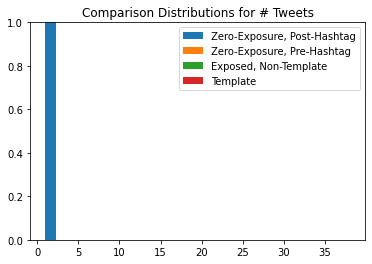

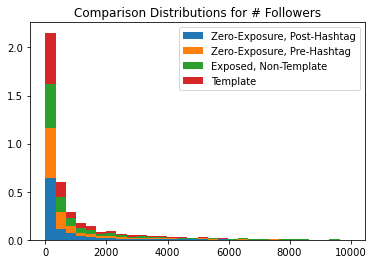

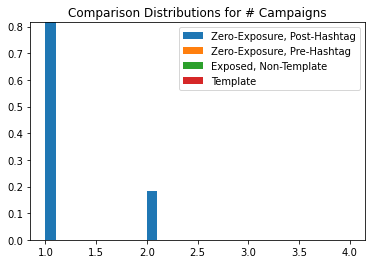

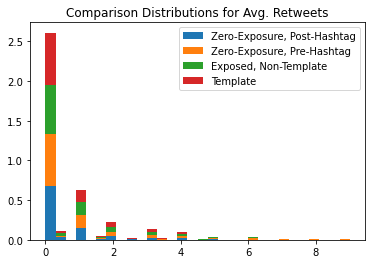

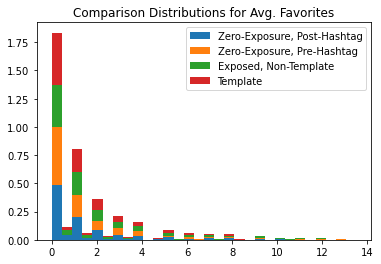

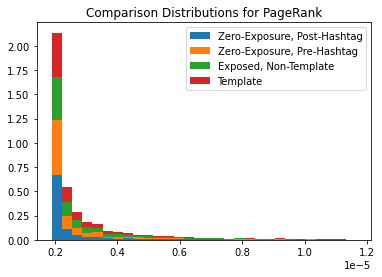

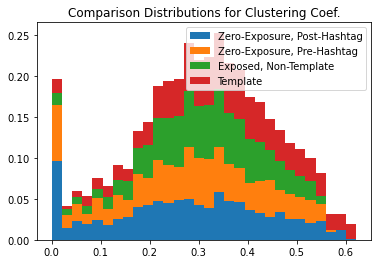

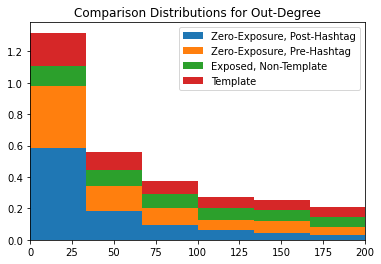

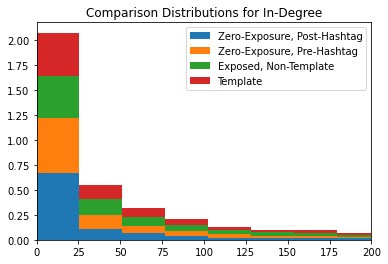

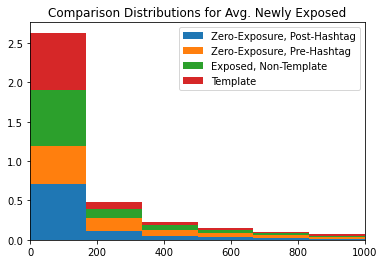

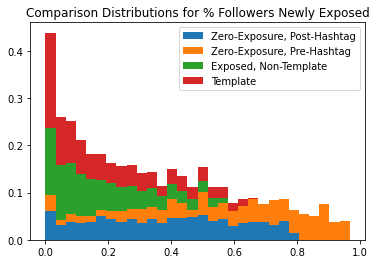

In [132]:
for c in columns_to_display:
    quantile = .9
    things = []
    for t in types:
        temper = temp[temp['Group'] == t][c]
#         print('type: ', t, len(temper))
        things.append(temper[temper < temper.quantile(quantile)])
    
    logx = False
    bins = 20
    if logx:
        hist, bins = np.histogram(temp[c].fillna(0), bins=bins)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.hist(things, bins=logbins, label=types, stacked=True)
        plt.xscale('log')
    else:
        normalize_hist_before_stack(things, label=types)
        # plt.hist(things, label=types, stacked=True, density=False, bins=20, log=False)
    if c in xlimit_settings:
        plt.xlim(xlimit_settings[c])
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

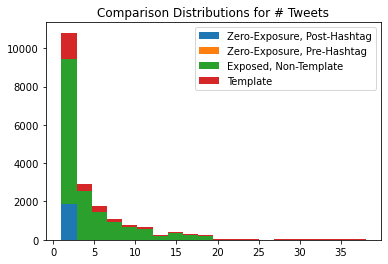

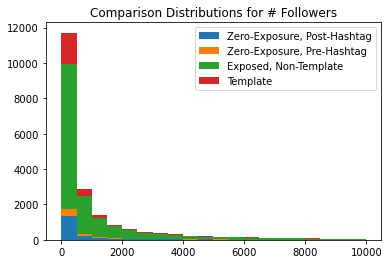

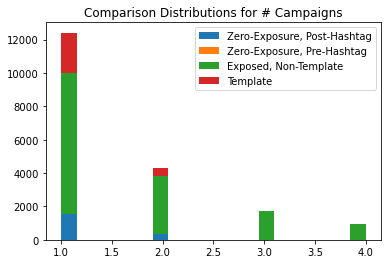

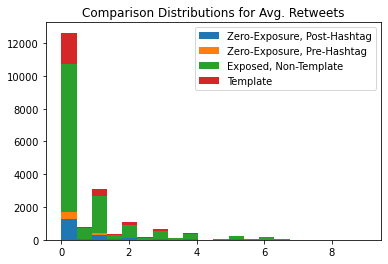

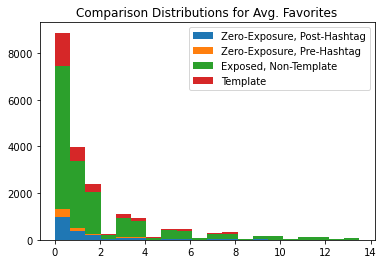

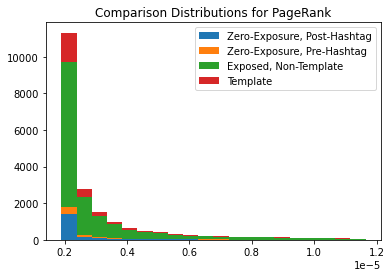

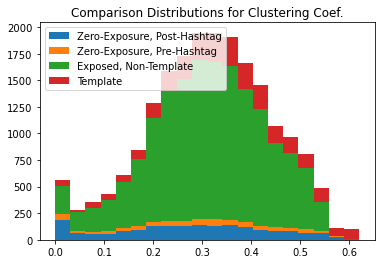

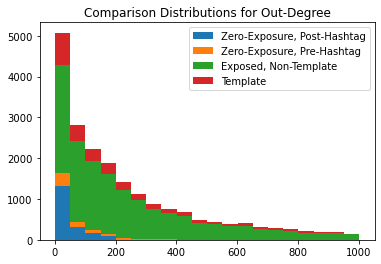

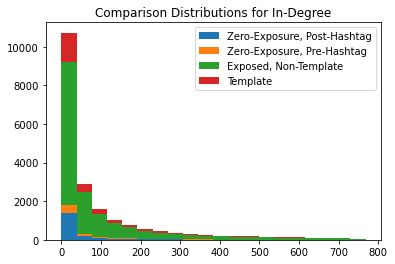

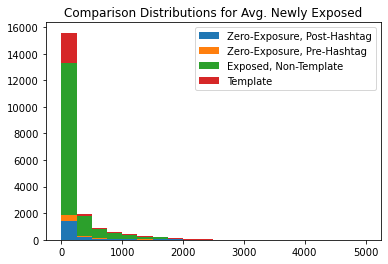

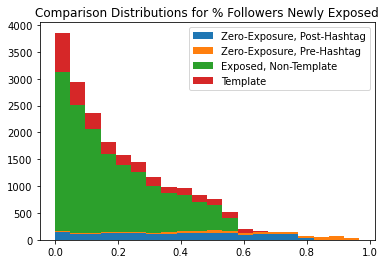

In [60]:
for c in columns_to_display:
    quantile = .9
    things = []
    for t in types:
        temper = temp[temp['Group'] == t][c]
        things.append(temper[temper < temper.quantile(quantile)])
    
    logx = False
    bins = 20
    if logx:
        hist, bins = np.histogram(temp[c].fillna(0), bins=bins)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.hist(things, bins=logbins, label=types, stacked=True)
        plt.xscale('log')
    else:
        plt.hist(things, label=types, stacked=True, density=False, bins=20, log=False)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

Automating these plots isn't really working so I'll just do them by hand

In [67]:
np.geomspace(0.001,1,20)

array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])

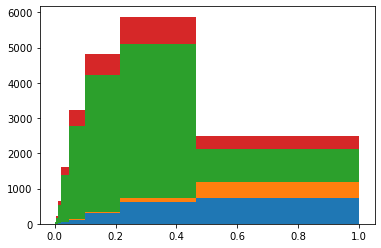

In [69]:
c = '% Followers Newly Exposed'
quantile = .9
things = []
for t in types:
    temper = temp[temp['Group'] == t][c]
    things.append(temper[temper < temper.quantile(quantile)])
    
_  = plt.hist(things, label=types, stacked=True, density=False, bins=np.geomspace(0.001,1,10), log=False)

    

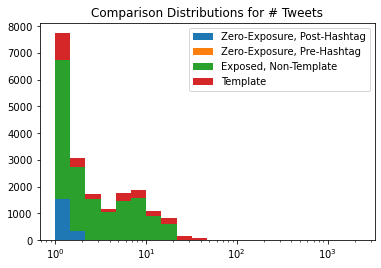

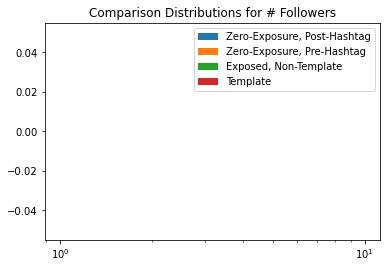

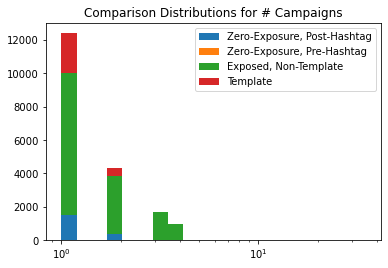

No handles with labels found to put in legend.


Avg. Retweets


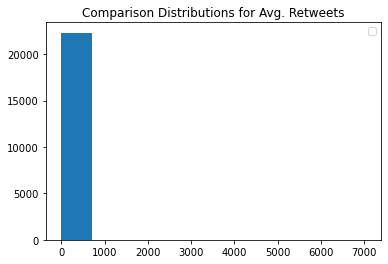

No handles with labels found to put in legend.


Avg. Favorites


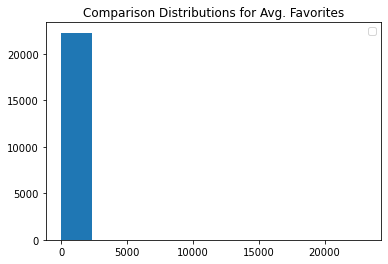

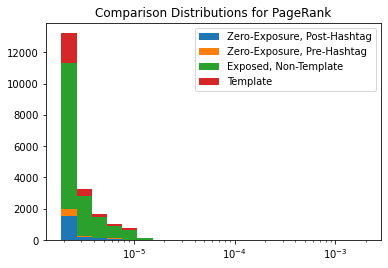

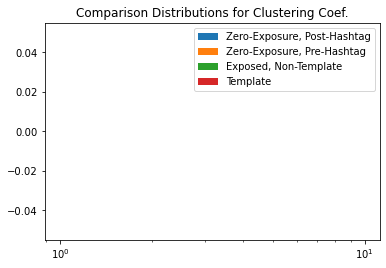

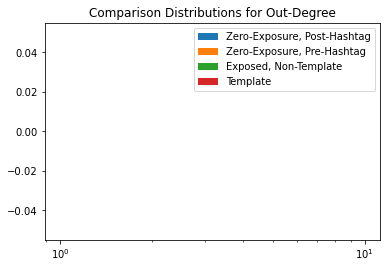

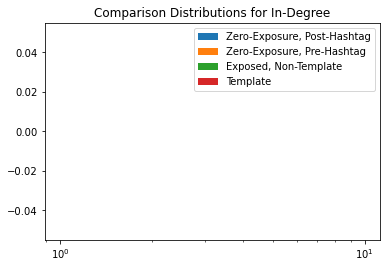

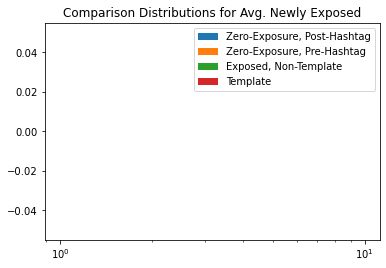

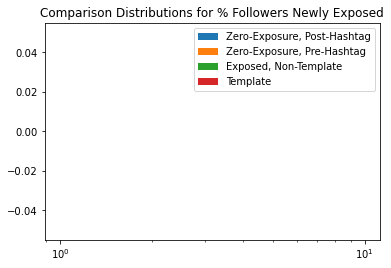

In [52]:
for c in columns_to_display:
    quantile = .9
    things = []
    for t in types:
        temper = temp[temp['Group'] == t][c]
        things.append(temper[temper < temper.quantile(quantile)])
    
    logx = True
    bins = 20
    if logx:
        try:
            hist, bins = np.histogram(temp[c], bins=bins)
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            plt.hist(things, bins=logbins, label=types, stacked=True)
            plt.xscale('log')
        except:
            plt.hist(temp[c])
            print(c)
    else:
        plt.hist(things, label=types, stacked=True, density=False, bins=20, log=False)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

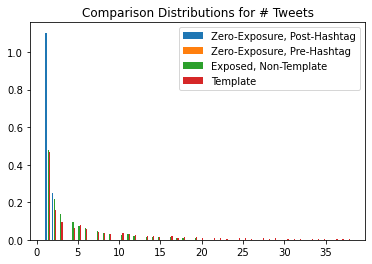

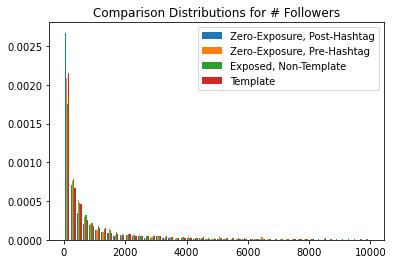

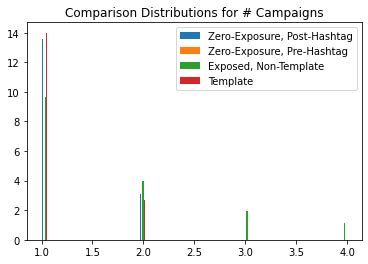

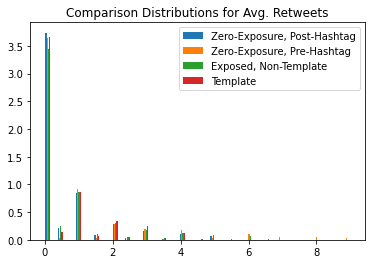

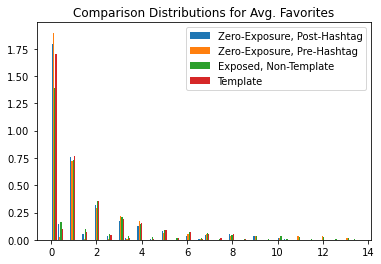

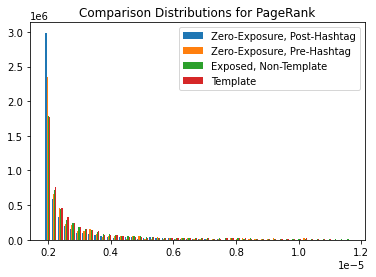

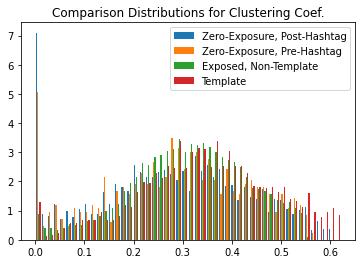

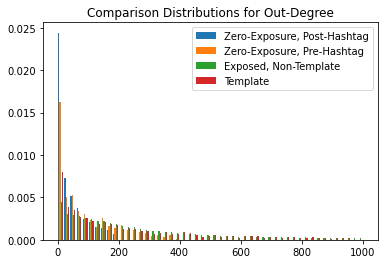

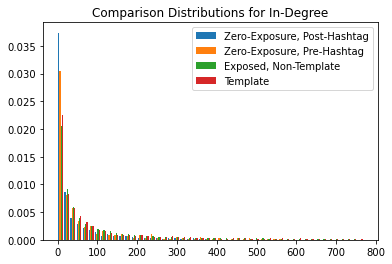

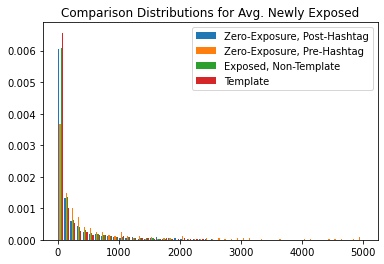

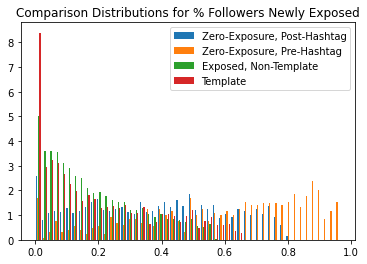

In [47]:
for c in columns_to_display:
    quantile = .9
    things = []
    for t in types:
        temper = temp[temp['Group'] == t][c]
        things.append(temper[temper < temper.quantile(quantile)])
        
    plt.hist(things, label=types, stacked=False, density=True, bins=50, log=False)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

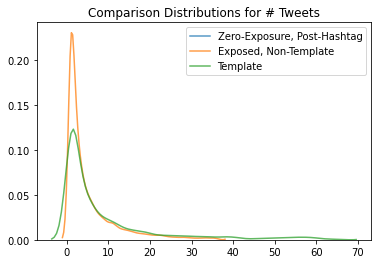

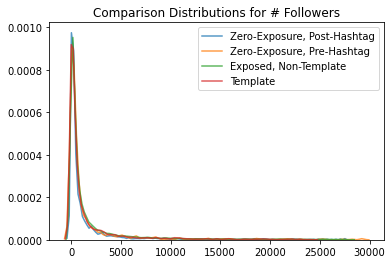

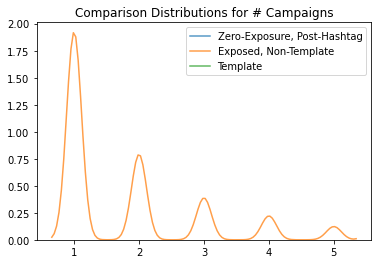

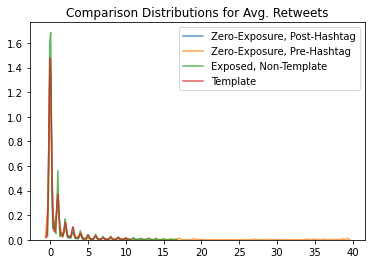

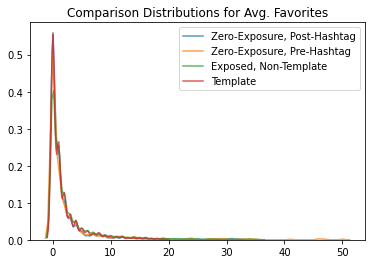

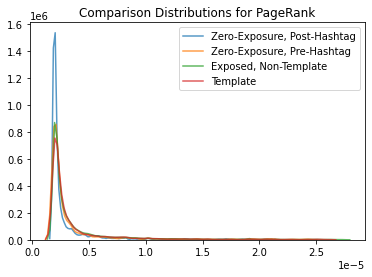

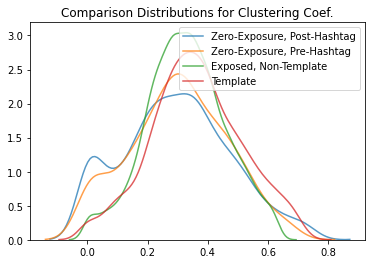

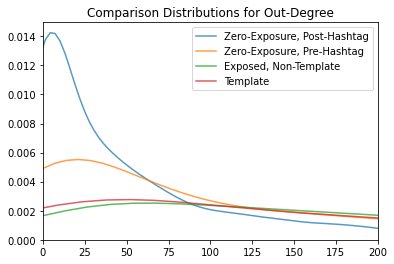

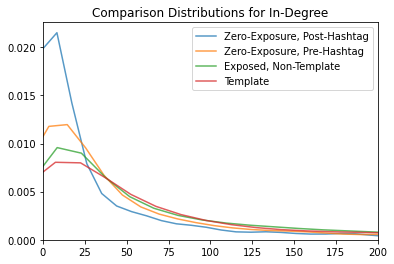

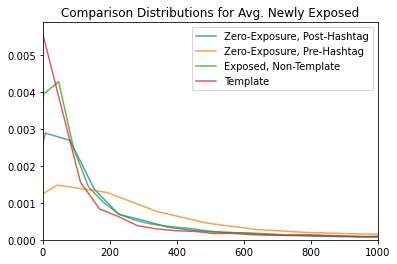

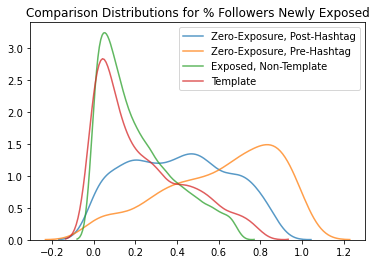

In [78]:
for c in columns_to_display:
    quantile = .95
    for t in types:
        temper = temp[temp['Group'] == t][c]
        sns.kdeplot(temper[temper < temper.quantile(quantile)], label=t,
                   alpha=.75)

    if c in xlimit_settings:
        plt.xlim(xlimit_settings[c])
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

# Examining The Disjoint

In [15]:
zero_exposure_tweeters.query('outdeg == 0')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,normal_exposure,total_exposure,time,trending_start,inferred_trending_start,hashtag,pr,cc,outdeg,indeg
adj_date,,,,,,,,,,,,,,,,,,,,,
2019-02-17 14:33:29,bjp4ichagarh,1097058944114089985,,,,झारखंड को प्रधानमंत्री जी की एक और सौगात #jhar...,2019-02-17 09:03:29,1,1,2019-02-17 14:33:29,...,0,0,2019-02-17 14:33:29,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.435574,0.0,85.0
2019-09-12 14:57:24,rajeevsondhibjp,1172079249953443840,,,,"आज आदिवासी बच्चों की, युवाओं की शिक्षा और उनके...",2019-09-12 09:27:24,0,1,2019-09-12 14:57:24,...,0,0,2019-09-12 14:57:24,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000008,0.206692,0.0,374.0
2019-02-17 14:21:04,bjp4ichagarh,1097055819063906304,,,,#jharkhand में 2014 तक सिर्फ 16 mw सौर ऊजा का ...,2019-02-17 08:51:04,1,1,2019-02-17 14:21:04,...,0,0,2019-02-17 14:21:04,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.435574,0.0,85.0
2019-09-12 14:54:25,rajeevsondhibjp,1172078502453006343,,,,हमने प्रधानमंत्री आवास योजना के माध्यम से 2 कर...,2019-09-12 09:24:25,0,4,2019-09-12 14:54:25,...,0,0,2019-09-12 14:54:25,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000008,0.206692,0.0,374.0
2019-09-12 14:58:39,rajeevsondhibjp,1172079566766006272,,,,ये एकलव्य स्कूल आदिवासी बच्चों की पढ़ाई-लिखाई ...,2019-09-12 09:28:39,0,1,2019-09-12 14:58:39,...,0,0,2019-09-12 14:58:39,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000008,0.206692,0.0,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-12 00:53:50,offersanddeals4,1050467027213676545,,,,💥💥😍skmei analog digital watches @ 91% off star...,2018-10-11 19:23:50,0,0,2018-10-12 00:53:50,...,0,0,2018-10-12 00:53:50,2018-10-11 23:30:00,2018-10-11 23:30:00,gappupappu,0.000002,0.000000,0.0,2.0
2018-10-12 13:16:34,aparichit70,1050653943078875136,,,,accept karo challange #gappupappu https://t.co...,2018-10-12 07:46:34,0,0,2018-10-12 13:16:34,...,0,0,2018-10-12 13:16:34,2018-10-11 23:30:00,2018-10-11 23:30:00,gappupappu,0.000002,0.833333,0.0,4.0
2018-10-27 16:18:53,aparichit70,1056135642038657024,,,,#gappupappu ki team se @rahulgandhi ji https:/...,2018-10-27 10:48:53,0,0,2018-10-27 16:18:53,...,0,0,2018-10-27 16:18:53,2018-10-11 23:30:00,2018-10-11 23:30:00,gappupappu,0.000002,0.833333,0.0,4.0


In [16]:
zero_exposure_tweeters.query('indeg == 0')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,normal_exposure,total_exposure,time,trending_start,inferred_trending_start,hashtag,pr,cc,outdeg,indeg
adj_date,,,,,,,,,,,,,,,,,,,,,
2019-09-25 22:58:46,trueself1950,1176911432983531520,,,,#bjp #haryanaassemblyelection #haryanaelection...,2019-09-25 17:28:46,1,0,2019-09-25 22:58:46,...,0,0,2019-09-25 22:58:46,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.326476,126.0,0.0
2019-09-19 11:11:05,trueself1950,1174559012139831296,,,,#modimadedisaster #modified100 #varanasi #utta...,2019-09-19 05:41:05,0,1,2019-09-19 11:11:05,...,0,0,2019-09-19 11:11:05,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.326476,126.0,0.0
2019-09-18 19:26:31,trueself1950,1174321304826044416,,,,#save2lakhjobs #syeraatrailer #ecigarettes #ec...,2019-09-18 13:56:31,2,0,2019-09-18 19:26:31,...,0,0,2019-09-18 19:26:31,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.326476,126.0,0.0
2019-09-12 11:59:11,trueself1950,1172034400550150146,,,,#haryana #jharkhand #jharkhandwithmodi #mahara...,2019-09-12 06:29:11,1,0,2019-09-12 11:59:11,...,0,0,2019-09-12 11:59:11,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.326476,126.0,0.0
2019-09-16 12:28:00,trueself1950,1173491207055368194,,,,#haryanaelection #haryana #maharashtra #mahara...,2019-09-16 06:58:00,0,0,2019-09-16 12:28:00,...,0,0,2019-09-16 12:28:00,2019-02-17 15:30:00,2019-02-17 14:20:00,jharkhandwithmodi,0.000002,0.326476,126.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-09 20:00:03,gumnamhai,1104388883599499264,,,,जब सैफ़ अली खान का बेटा तैमूर अली खान है तो फ़...,2019-03-09 14:30:03,27,31,2019-03-09 20:00:03,...,0,0,2019-03-09 20:00:03,2019-03-09 15:30:00,2019-03-09 15:30:00,modifiedjobs,0.000002,0.266667,6.0,0.0
2019-01-04 21:14:26,gargmanishindia,1081214780487159808,,,,#rafaledramaflops #gappupappu made a big mocke...,2019-01-04 15:44:26,0,0,2019-01-04 21:14:26,...,0,0,2019-01-04 21:14:26,2018-10-11 23:30:00,2018-10-11 23:30:00,gappupappu,0.000002,0.711111,10.0,0.0
2019-01-02 23:14:20,gargmanishindia,1080520180462223360,,,,dear #rahulgandhi #gappupappu #mahagathbandhan...,2019-01-02 17:44:20,1,0,2019-01-02 23:14:20,...,0,0,2019-01-02 23:14:20,2018-10-11 23:30:00,2018-10-11 23:30:00,gappupappu,0.000002,0.711111,10.0,0.0


In [24]:
zero_exposure_tweeters.query('outdeg == 0 and indeg == 0')

username                                                        vishalcincmp
id                                                       1195479544301412352
retweet_from                                                                
template                                                                    
retweet_id                                                                  
text                       😡waiting for my first subscriber😡 -&gt;https:/...
date                                                     2019-11-15 23:11:48
retweets                                                                 126
favorites                                                                786
adj_date                                                 2019-11-16 04:41:48
type                                                                 regular
follower_data                                                           True
template_exposure                                                          0

In [34]:
zero_exposure_tweeters.query('outdeg == 0 and indeg == 0').join(user_df, on='username', rsuffix='_userdf').sort_values('followers')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,id_userdf,location,description,followers,friends,statuses,type_userdf,new_description,temp,group
adj_date,,,,,,,,,,,,,,,,,,,,,
2019-05-10 19:16:15,rabta25,1126845912460840960,,,,@satyasanatanind @opindia_com @aktkadmin @zee5...,2019-05-10 13:46:15,0,0,2019-05-10 19:16:15,...,893853582134358016,,,1,4,1632,6_non-participant,None,non-participant,0
2019-07-12 12:02:57,rabta25,1149567300502081537,,,,@rohini_sgh @boogiepest @one_by_two @theprinti...,2019-07-12 06:32:57,0,0,2019-07-12 12:02:57,...,893853582134358016,,,1,4,1632,6_non-participant,None,non-participant,0
2019-06-20 19:37:56,rabta25,1141709270473330690,,,,@aktkadmin @zee5telugu @bjpsamvad @bjp4india @...,2019-06-20 14:07:56,0,0,2019-06-20 19:37:56,...,893853582134358016,,,1,4,1632,6_non-participant,None,non-participant,0
2019-05-03 21:33:34,rabta25,1124343752892358656,,,,@tv1telugu @bengalurufc @blrcitypolice @incind...,2019-05-03 16:03:34,0,0,2019-05-03 21:33:34,...,893853582134358016,,,1,4,1632,6_non-participant,None,non-participant,0
2019-05-02 18:33:10,rabta25,1123935964655702020,,,,@incindia @jaitdp @satyasanatanind @opindia_co...,2019-05-02 13:03:10,0,0,2019-05-02 18:33:10,...,893853582134358016,,,1,4,1632,6_non-participant,None,non-participant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-09 19:19:40,astradiscover,1104378720956137472,,,,😀waiting for my first subscriber😀 -&gt;https:/...,2019-03-09 13:49:40,1,1,2019-03-09 19:19:40,...,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0
2019-03-09 19:21:00,astradiscover,1104379058492706816,,,,😀waiting for my first subscriber😀 -&gt;https:/...,2019-03-09 13:51:00,1,1,2019-03-09 19:21:00,...,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0
2019-03-09 20:25:46,astradiscover,1104395355846836227,,,,😀waiting for my first subscriber😀 -&gt;https:/...,2019-03-09 14:55:46,1,1,2019-03-09 20:25:46,...,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0


In [15]:
def annotate(df):
    df['hashtags_used'] = df.text.apply(lambda x: x.count('#'))
    df['users_tagged'] = df.text.apply(lambda x: x.count('@'))
    df['includes_link'] = df.text.apply(lambda x: 'http' in x)
    return df

In [17]:
def print_tweets(df):
    for time, row in df.iterrows():
        if label_tweet(row.text):
            print('--', row.username)
        #print(f'{row.text}\n--{row.username}, {row.followers} followers, {row.friends} friends\n')

In [18]:
len(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))

83

In [19]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))

make this video most disliked video please --&gt;https://t.co/nzsdetcsda&lt;-- #pulwamaterrorattacks #successofmakeinindia #exposedeshdrohis #timeforrevenge geelani yasin malik abdul ghani bhat mirwaiz umar farooq #jharkhandwithmodi ck khanna
#the best pm of india in last 70 years! real statesman, visionary leader, real karm yogi, india is lucky to have such a great pm, we have not seen any pm earlier with the energy to work like @narendramodi ji 👏🙏 #merapmmeraabhimaan #modi #narendramodi #chhattisgarhelections https://t.co/yesnwputri
నేడే 'కియా' తొలి కారు ఆవిష్కరణ!!!!! అనంతపురం ప్రయోగశాలలో శ్రీకారం నేడే రోడ్డెక్కనున్న కియా కారు... #kiamadeinap #kiafirstcarinap #kiainandhra #kiainindia #kia https://t.co/prfivgqsnf
@satyasanatanind @opindia_com @aktkadmin @zee5telugu @bjpsamvad @bjp4india @ipl #ipl2019 #bengalurusouth #bengali #westbengal #kolkata #indianmuslims @imonewsonline @indianmusl #timesofrahul #pappukachelapappu #pappudiwas #pappu #pappujhoothahai https://t.co/3wwnsu2fka
wishin

In [162]:
len(temp.username.unique())

51

In [157]:
len(temp)

83

In [171]:
temp.hashtags_used.mean()

4.674698795180723

In [170]:
temp.includes_link.mean()

0.6506024096385542

In [169]:
user_df.loc['ajay2u21']

templates                            0
template_retweets                    0
tweets                               6
retweets                             0
campaigns                            0
id                           405401807
location                 mumbai, india
description                        🙏😘🙏
followers                           24
friends                             98
statuses                          2384
type                 6_non-participant
new_description                   None
temp                   non-participant
group                                0
Name: ajay2u21, dtype: object

In [20]:
from config import CASCADE_DIR

In [22]:
import graph_tool.all as gt
gt.load_graph(os.path.join(CASCADE_DIR, '1123982001294516225_temporal.gt'))

<Graph object, directed, with 4 vertices and 3 edges, 1 internal vertex property, at 0x2aaaf9eda910>

In [175]:
temp.loc[32254]

username                                                            ajay2u21
id                                                       1123982001294516225
retweet_from                                                                
template                                                                    
retweet_id                                                                  
text                       grand welcome 😍🙏😍 कश्मीरी पंडितों का घर वापसी ...
date                                                     2019-05-02 16:06:06
retweets                                                                 126
favorites                                                                786
adj_date                                                 2019-05-02 21:36:06
type                                                                 regular
follower_data                                                           True
template_exposure                                                          0

In [168]:
temp.sort_values('retweets')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,inferred_trending_start,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
43558,revatiramanpan7,1116572490766045189,,,,घर में बैठकर गालियाँ देने से आतंकवादी नहीं मरा...,2019-04-12 05:23:21,0,0,2019-04-12 10:53:21,...,2019-01-22 08:30:00,लक्ष्य_हमारा_मोदी_दोबारा,0,1.9e-06,0,0,0,1,0,False
1354,stockma80935639,1082527271099875328,,,,vakrangee में अब क्या किया जाये ? कभी upper ci...,2019-01-08 06:39:48,0,1,2019-01-08 12:09:48,...,2019-01-08 08:30:00,congresseurofighterscandal,3,1.9e-06,0,0,0,6,0,True
1228,meravotemeriaw1,1082521248016592902,,,,#cbivscbi #bharatbandh #alokverma #university ...,2019-01-08 06:15:52,0,1,2019-01-08 11:45:52,...,2019-01-08 08:30:00,congresseurofighterscandal,13,1.9e-06,0,0,0,11,0,True
2718,sksourav10,1062977781737369600,,,,#ahsapocalypse #cmaawards #الخميس #eltonjohnle...,2018-11-15 07:57:06,0,1,2018-11-15 13:27:06,...,2018-11-15 09:30:00,ragafailonrafale,96,1.9e-06,0,0,0,10,0,True
2171,movies_it,1062979425761865728,,,,sonakshi sinha!! . . . #deepikaranveer #sonaks...,2018-11-15 08:03:38,0,0,2018-11-15 13:33:38,...,2018-11-15 09:30:00,ragafailonrafale,0,1.9e-06,0,0,0,27,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,navraj_dey,1111884783448215552,,,,99%of what modi utters seems fake &amp; lies.....,2019-03-30 06:56:04,2,3,2019-03-30 12:26:04,...,2019-03-30 08:30:00,maikamalkhilaneayahu,1,1.9e-06,0,0,0,1,0,False
693,sachi_mahe,1073842785860513792,,,,congress ka maalik moron hai? #justasking 👉 rt...,2018-12-15 07:30:45,2,0,2018-12-15 13:00:45,...,2018-12-15 10:30:00,rafailgandhi,11,1.9e-06,0,0,0,14,0,True
840,astradiscover,1093157068675186688,,,,https://t.co/jrnmujiimf #pubglive #pubgmobile ...,2019-02-06 14:38:49,2,3,2019-02-06 20:08:49,...,2019-02-06 19:30:00,sizeindia,7,1.9e-06,0,0,0,12,0,True
14082,sgoswami41,1070227184642478080,,,,"though i am not a citizen of #rajasthan, had i...",2018-12-05 08:03:39,3,8,2018-12-05 13:33:39,...,2018-12-05 10:30:00,म्हारा_वोट_भाजपा_को,3,1.9e-06,0,0,0,2,0,False


In [23]:
temp = annotate(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))


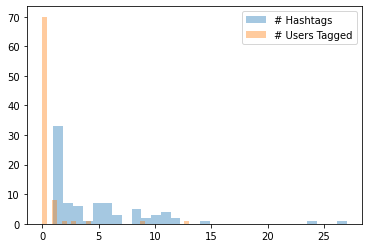

In [28]:
plt.hist(temp.hashtags_used, bins=30, alpha=.4, label='# Hashtags')#, density=True)
plt.hist(temp.users_tagged, bins=30, alpha=.4, label='# Users Tagged')#, density=True)

plt.legend()

In [21]:
temp

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,inferred_trending_start,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
10202,astradiscover,1097122057329000448,,,,make this video most disliked video please --&...,2019-02-17 13:14:16,1,1,2019-02-17 18:44:16,...,2019-02-17 14:20:00,jharkhandwithmodi,5.0,0.000002,0.0,0.0,0.0,5,0,True
12553,nobeatinground1,1061579553435398144,,,,"#merapmmeraabhimaan ""india can’t work from the...",2018-11-11 11:21:03,0,1,2018-11-11 16:51:03,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12554,nobeatinground1,1061581524653420544,,,,#merapmmeraabhimaan for the first time we have...,2018-11-11 11:28:53,0,0,2018-11-11 16:58:53,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12555,nobeatinground1,1061583862730387459,,,,"#merapmmeraabhimaan ""imaandar kamdaar chowkida...",2018-11-11 11:38:10,0,1,2018-11-11 17:08:10,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12556,nobeatinground1,1061584354852274178,,,,#merapmmeraabhimaan they abused mr modi from 2...,2018-11-11 11:40:08,0,2,2018-11-11 17:10:08,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,babypusarla,1104437442160013314,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:43:00,0,0,2019-03-09 23:13:00,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1653,babypusarla,1104432422278508544,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:23:03,0,1,2019-03-09 22:53:03,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1654,babypusarla,1104432605724729345,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:23:47,0,0,2019-03-09 22:53:47,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1655,babypusarla,1104440461836447745,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:55:00,0,0,2019-03-09 23:25:00,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True


In [15]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))
             #.join(user_df, on='username', rsuffix='_userdf').sort_values('followers', ascending=False))

link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
master tagger
link
link
link
link
l

In [36]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0').\
             join(user_df, on='username', rsuffix='_userdf').sort_values('followers', ascending=False))

https://t.co/bugpyahjqp #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

very simple data entry job full bangla tutorial 2018 || data entry=========== https://t.co/uau73sugxu #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

https://t.co/eptu6f7sim #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

#5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11 https://t.co/mw

In [28]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))

make this video most disliked video please --&gt;https://t.co/nzsdetcsda&lt;-- #pulwamaterrorattacks #successofmakeinindia #exposedeshdrohis #timeforrevenge geelani yasin malik abdul ghani bhat mirwaiz umar farooq #jharkhandwithmodi ck khanna
--astradiscover

#merapmmeraabhimaan "india can’t work from the centre, says raghuram rajan" "india works from every home, frm every kitchen, frm every field, frm every shed, frm every factory, frm every office, frm every school, frm every hospital, and we are all inspired by our pm."
--nobeatinground1

शरद यादव ने कल बोफ़ोर्स ग़लती से नहीं बल्कि जानबूझकर कहा था क्यूँकि बुड्ढा हमारे राहुल बाबा से जलता है ओर उनकी जगह मायावती को प्रधानमंत्री बनाना चाहता है 😂😂😂 #merapmmeraabhimaan #meraboothsabsemazboot #namoagain2019 #modi5yearchallenge
--memerhoonbsdk

#merapmmeraabhimaan for the first time we have a pm whose family has not made politics a business. every single member of his family is living an ordinary indian citizen's life. if india has to progr

In [32]:
zero_exposure_tweeters.join(user_df, on='username', rsuffix='_userdf')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,id_userdf,location,description,followers,friends,statuses,type_userdf,new_description,temp,group
adj_date,,,,,,,,,,,,,,,,,,,,,
2019-02-17 17:39:00,sanjeevkr868,1097105854694752272,,,,pm मोदी ने रविवार को हजारीबाग में झारखंड को कई...,2019-02-17 12:09:00,0,0,2019-02-17 17:39:00,...,2441946972,,"समर शेष है, नही पाप का भागी केवल व्याध, जो त...",2442,3526,34652,4_other,"समर शेष है, नही पाप का भागी केवल व्याध, जो त...",समर शेष है नही पाप का भागी केवल व्याध जो तटस्...,1
2019-09-11 23:06:06,bjp4india,1171839848732340224,,,,प्रधानमंत्री श्री @narendramodi के 12 सितम्बर ...,2019-09-11 17:36:06,292,1594,2019-09-11 23:06:06,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-09-12 14:13:38,bjp4india,1172068238961692672,,,,आज यहां आदिवासी बच्चों की शिक्षा और उनके कौशल ...,2019-09-12 08:43:38,133,487,2019-09-12 14:13:38,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-09-12 15:13:56,bjp4india,1172083411713835008,,,,मैंने कहा था कि नई सरकार बनते ही पीएम किसान सम...,2019-09-12 09:43:56,550,3004,2019-09-12 15:13:56,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-02-17 15:55:00,bjp4india,1097079676378312704,,,,3 वर्ष पहले झारखण्ड में केवल 3 मेडिकल कॉलेज थे...,2019-02-17 10:25:00,699,2102,2019-02-17 15:55:00,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-12 15:54:40,sourabhtamesh,1050693726907977729,,,,@rahulgandhi #gappupappu https://t.co/ximdwjkjzo,2018-10-12 10:24:40,0,0,2018-10-12 15:54:40,...,802408362239520768,ganj basoda,"विद्यार्थी, जिज्ञासु, आत्मविश्वासी, गर्वित भार...",119,150,1861,6_non-participant,None,non-participant,0
2018-10-17 18:44:43,aparichit70,1052548460736651264,,,,#gappupappu https://t.co/q9h58e3smq,2018-10-17 13:14:43,0,0,2018-10-17 18:44:43,...,1048465504967516160,"basoda, india","😃indian😃, fan apne @narendramodi ka",23,199,1182,6_non-participant,None,non-participant,0
2018-10-12 06:44:39,ljitu5183,1050555310841241600,,,,#navratri अवश्य जानिए कि दुर्गा जी सब बातों को...,2018-10-12 01:14:39,0,0,2018-10-12 06:44:39,...,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0


# Comparing Distributions of Network Stats
want to compare in-degree, out-degree, number of followers, etc

In [140]:
df_list = [zero_exposure_tweeters, templates, others, zero_exposure_tweeters_pre_trend]
types = ['zero_exposure_post_trending', 'template', 'others', 'zero_exposure_tweeter_pre_trend']
transformed_df_list = []
for df, lab in zip(df_list, types):
    temp = df.join(user_df, on='username', rsuffix='_userdf')
    temp['label'] = lab
    transformed_df_list.append(temp.drop_duplicates(subset=['username', 'label']))
    

In [141]:
temp = pd.concat(transformed_df_list)

In [146]:
temp.columns

Index(['username', 'id', 'retweet_from', 'template', 'retweet_id', 'text',
       'date', 'retweets', 'favorites', 'adj_date', 'type', 'follower_data',
       'template_exposure', 'normal_exposure', 'total_exposure', 'time',
       'trending_start', 'inferred_trending_start', 'hashtag',
       'newly_exposed_users', 'pr', 'cc', 'outdeg', 'indeg', 'templates',
       'template_retweets', 'tweets', 'retweets_userdf', 'campaigns',
       'id_userdf', 'location', 'description', 'followers', 'friends',
       'statuses', 'type_userdf', 'new_description', 'temp', 'group', 'label'],
      dtype='object')

In [150]:
columns_to_display = ['outdeg', 'indeg', 'followers', 'friends', 
                      'pr', 'retweets', 'favorites', 'newly_exposed_users']

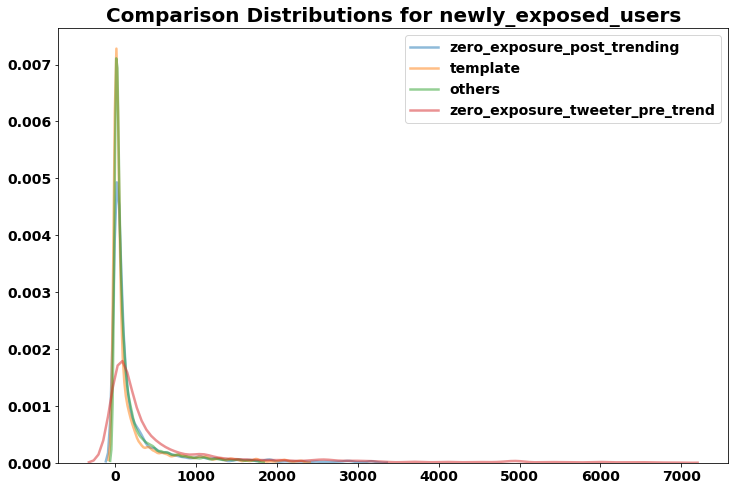

In [155]:
columns_to_display = ['newly_exposed_users']
for c in columns_to_display:
    quantile = .9
    for t in types:
        temper = temp[temp['label'] == t][c]
        sns.kdeplot(temper[temper < temper.quantile(quantile)], label=t,
                   alpha=.5)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


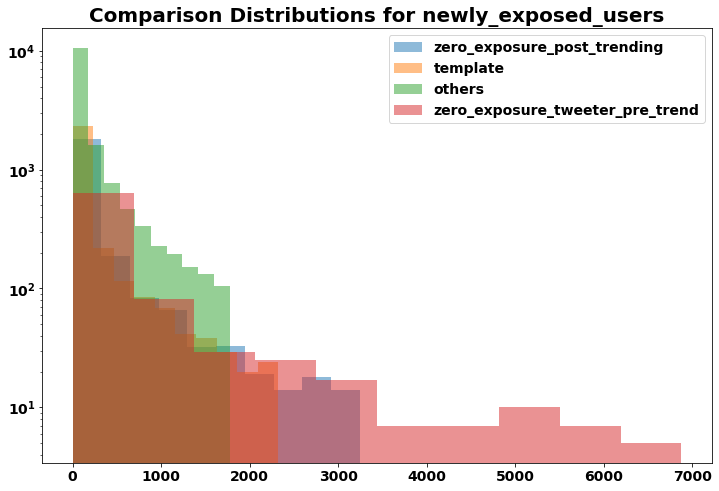

In [157]:
columns_to_display = ['newly_exposed_users']
for c in columns_to_display:
    quantile = .9
    for t in types:
        temper = temp[temp['label'] == t][c]
        plt.hist(temper[temper < temper.quantile(quantile)], label=t, alpha=.5, log=True)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

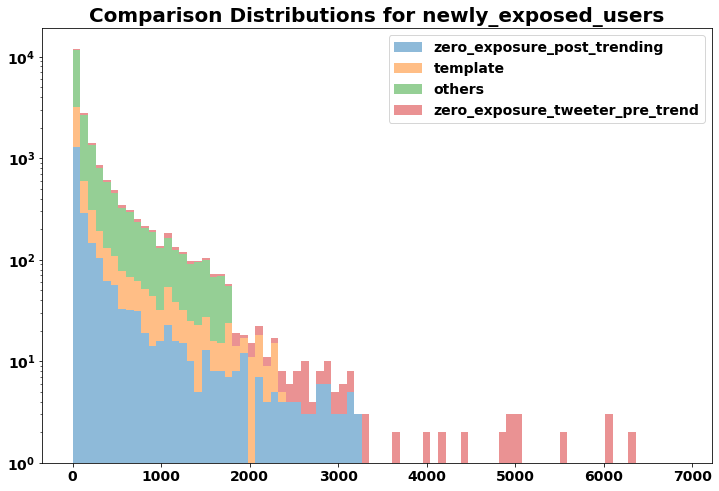

In [164]:
columns_to_display = ['newly_exposed_users']
for c in columns_to_display:
    quantile = .9
    to_plot = []
    for t in types:
        temper = temp[temp['label'] == t][c]
        to_plot.append(temper[temper < temper.quantile(quantile)])
    plt.hist(to_plot, label=types, alpha=.5, log=True, stacked=True, bins=80)
    
    plt.title('Comparison Distributions for ' + c)
    plt.legend()
    plt.show()

In [136]:
temp.indeg < temp.indeg.quantile(.95)

568      True
1167     True
1544     True
2107     True
6283    False
        ...  
3582     True
3858     True
118      True
704      True
1009     True
Name: indeg, Length: 5808, dtype: bool

(array([1.4738e+04, 2.2500e+02, 1.2000e+02, 1.0000e+01, 2.4000e+01,
        1.0000e+00, 2.3000e+01, 0.0000e+00, 0.0000e+00, 3.6800e+02]),
 array([    0.,  4910.,  9820., 14730., 19640., 24550., 29460., 34370.,
        39280., 44190., 49100.]),
 <BarContainer object of 10 artists>)

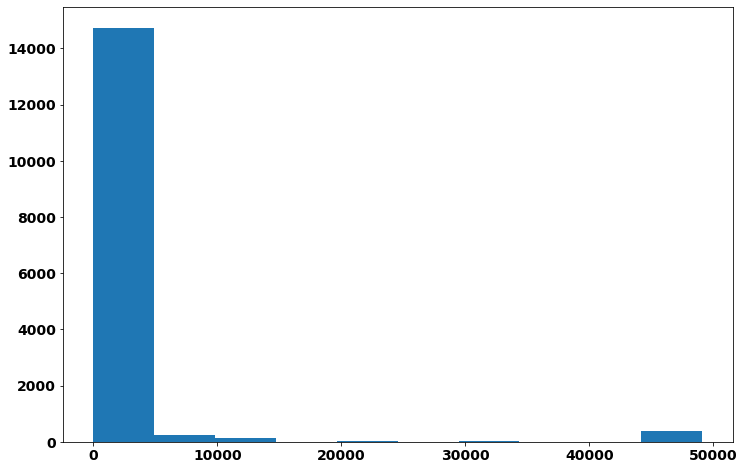

In [40]:
plt.hist(zero_exposure_tweeters.indeg)